**Parkinson Disease Prediction using Machine Learning - Python**

Parkinson's Disease is a progressive neurological disorder with 4 classical symptoms that include muscle stiffness, tremors, impaired balance and co-ordination, and slowness of movement. The following project aims to predict parkinson's disease based on specific biomarkers using Machine learning.

1. **Importing Libraries**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

2. **Importing Dataset & EDA**


The dataset we are going to use here includes 755 columns and three observations for each patient. The values' ineach of these columns are part of some other diagnostics which are generally used to capture the difference between a healthy and affected person.


In [2]:
df = pd.read_csv("parkinson_disease.csv")
pd.set_option('display.max_columns', 10)
df.sample(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
626,208,1,0.82687,0.71823,0.44413,...,3.2586,3.2981,3.8534,3.1418,1
745,248,1,0.15273,0.69326,0.58112,...,2.4948,5.7007,8.1208,2.9888,1
648,216,0,0.78102,0.66945,0.40831,...,27.1005,18.2890,14.8293,5.2528,0
518,172,0,0.79190,0.59987,0.30515,...,3.0743,6.1370,4.4167,4.1060,1
171,57,0,0.79414,0.75269,0.67407,...,4.4842,6.8440,7.2086,7.9552,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [4]:
df.describe()

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,...,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,...,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,...,1.628700,1.861700,1.955900,2.364000,0.000000
25%,62.750000,0.000000,0.762833,0.647053,0.386537,...,3.114375,3.665925,3.741275,3.948750,0.000000
50%,125.500000,1.000000,0.809655,0.700525,0.484355,...,4.741450,6.725700,7.334250,10.637250,1.000000
75%,188.250000,1.000000,0.834315,0.754985,0.586515,...,12.201325,21.922050,22.495175,61.125325,1.000000
max,251.000000,1.000000,0.907660,0.852640,0.871230,...,73.532200,62.007300,57.544300,156.423700,1.000000


'Class' is the target variable in this dataset.
class = 1 → Parkinson's disease,
class = 0 → Healthy control

In [5]:
df['class'].value_counts()


,count
class,
1,564
0,192


In [6]:
df.isnull().sum().sum()

np.int64(0)

The dataset contains no null/missing values.

In [7]:
df.duplicated().sum()

np.int64(1)

There is exactly 1 duplicate row in our dataset that can be dropped.

In [8]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

np.int64(0)

3. **Data Wrangling**


As mentioned, the dataset contains three observations for each patient and so, we need to aggregate them by the "id" column to create a single representative record per patient.


In [9]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

Groups the dataset by the "id" column and calculates the mean of numerical features, and then the id column is dropped since 'id's are not used for ML.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 754 entries, gender to class
dtypes: float64(754)
memory usage: 1.4 MB


In a very high-dimensional dataset like this, it is important to identify and handle highly-correlated features. Multicolllinearity leads to standard errors that can make the machine learning model's results less interpretable and reliable.

Next up, 'Pearson correlation coefficient' b/w two numerical features is computed and if the correlation coefficient value exceeds 0.7, the feature is considered highly correlated and is removed from the dataset to reduce redundancy.

In [11]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
    # If the correlation between the two features is more than 0.7, one of them is removed to reduce redundancy.
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    df = df[filtered_columns]
df.shape

(252, 286)

After the removal of highly-correlated feature variables, the feature space is now reduced to 287 columns. However, this count still exceeds the number of data points(252).

4. **Feature Selection**: To improve model performance and reduce computational complexity, using the chi-square test to retain only the most relevant features.

In [12]:
X = df.drop('class', axis=1) #target variable 'class' is removed to extract the feature set.
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

→ 30 selected features + 1 class

5. **Handling Class Imbalance and Splitting Data**: a pie chart can be used to represent the distribution of target classes in the dataset, to check for class imbalances.

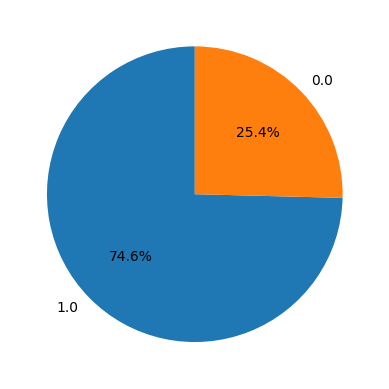

In [13]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        startangle= 90,
        autopct='%1.1f%%')
plt.show()

In [14]:
class_counts = df['class'].value_counts()
class_percent = class_counts / class_counts.sum() * 100

class_distribution = pd.DataFrame({
    'Count': class_counts,
    'Percentage (%)': class_percent
})

class_distribution

,Count,Percentage (%)
class,,
1.0,188,74.603175
0.0,64,25.396825


**Class distribution analysis revealed a significant imbalance, with Parkinson’s disease class (1) being over-represented.**

**ML models may become biased toward majority class**

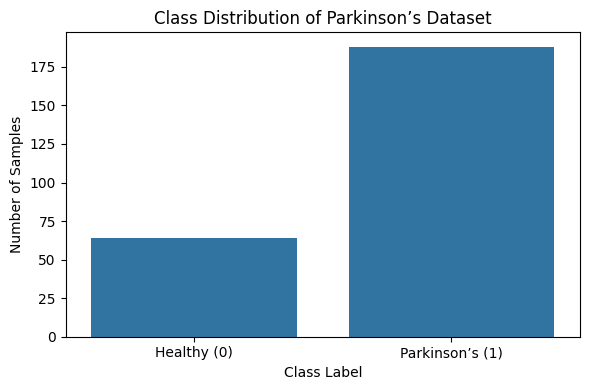

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Parkinson’s Dataset')
plt.xticks([0, 1], ['Healthy (0)', 'Parkinson’s (1)'])

plt.tight_layout()
plt.show()


6. Handling the class imbalance using 'Random Over Sampler', that generates classes with low examples and is followed by random resampling.

In [16]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

7. **Model Training and Evaluation**:  Three different classifiers namely, Logistic Regression, XGBoost Classifier, and Support Vector Classifiers are trained and evaluated using the ROC-AUC score.

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

models = [
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ),
    XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ),
    SVC(kernel='rbf', probability=True, class_weight='balanced')
]

for model in models:
    model.fit(X_train, Y_train)
    print(f"{model.__class__.__name__}:")

    # ---- ROC-AUC on training data ----
    train_probs = model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(Y_train, train_probs)
    print("Training ROC-AUC :", round(train_auc, 3))

    # ---- ROC-AUC on validation data ----
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(Y_val, val_probs)
    print("Validation ROC-AUC :", round(val_auc, 3))
    print("-" * 40)

LogisticRegression:
Training ROC-AUC : 0.855
Validation ROC-AUC : 0.79
----------------------------------------
RandomForestClassifier:
Training ROC-AUC : 1.0
Validation ROC-AUC : 0.784
----------------------------------------
XGBClassifier:
Training ROC-AUC : 1.0
Validation ROC-AUC : 0.799
----------------------------------------
SVC:
Training ROC-AUC : 0.67
Validation ROC-AUC : 0.707
----------------------------------------


8. **Analyzing Model Performance:
Confusion Matrix ~ XGBoost Classifier**

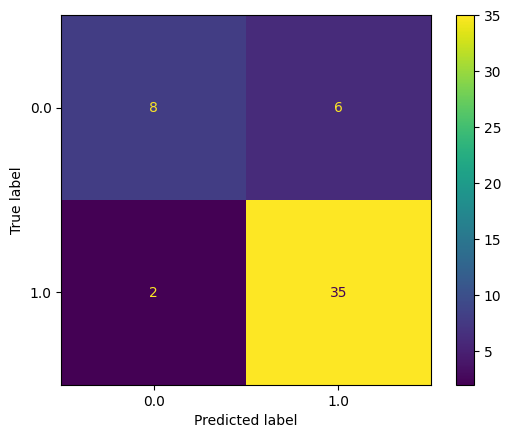

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[2], X_val, Y_val)
plt.show()

 **Classification Report ~ XGBoost Classifier**

In [19]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, models[2].predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.85      0.95      0.90        37

    accuracy                           0.84        51
   macro avg       0.83      0.76      0.78        51
weighted avg       0.84      0.84      0.83        51



**Analyzing Model Performance: Confusion Matrix ~ Random Forest Classifier**

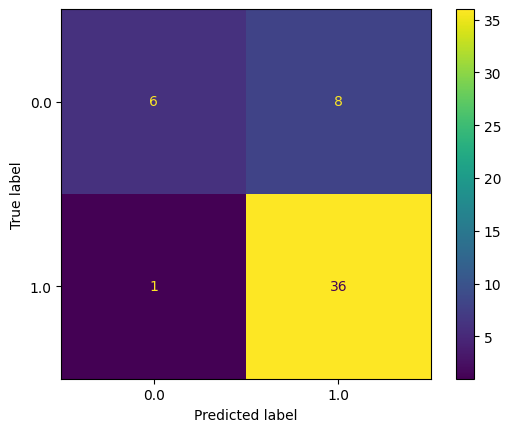

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[1], X_val, Y_val)
plt.show()

**Classification Report ~ Random Forest Classifier**

In [21]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, models[1].predict(X_val)))


              precision    recall  f1-score   support

         0.0       0.86      0.43      0.57        14
         1.0       0.82      0.97      0.89        37

    accuracy                           0.82        51
   macro avg       0.84      0.70      0.73        51
weighted avg       0.83      0.82      0.80        51



**Random Forest Classifier slightly outperforms XGBoost in recall(0.97) & F1(0.91)**

9. **ROC–AUC for Both Models**

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
rf_probs  = models[1].predict_proba(X_val)[:, 1]   # Random Forest
xgb_probs = models[2].predict_proba(X_val)[:, 1]   # XGBoost

# ROC-AUC scores
rf_auc  = roc_auc_score(Y_val, rf_probs)
xgb_auc = roc_auc_score(Y_val, xgb_probs)

print(f"Random Forest ROC-AUC : {rf_auc:.3f}")
print(f"XGBoost ROC-AUC       : {xgb_auc:.3f}")


Random Forest ROC-AUC : 0.784
XGBoost ROC-AUC       : 0.799


**Plotting the ROC-AUC curves**

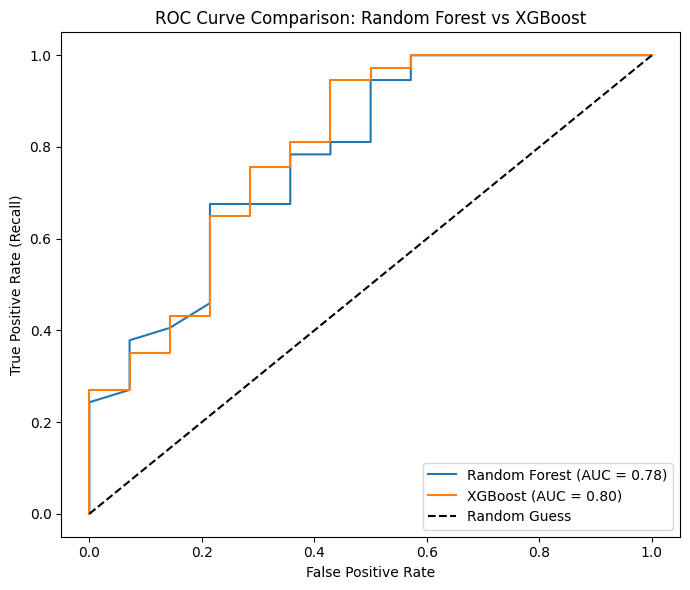

In [23]:
rf_fpr, rf_tpr, _   = roc_curve(Y_val, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(Y_val, xgb_probs)

plt.figure(figsize=(7, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Comparison: Random Forest vs XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


10. **Conclusion**: ROC curve analysis demonstrated strong discriminatory performance for both models, with XGBoost achieving a marginally higher AUC (0.80) than Random Forest (0.78). However, the difference is minimal, and Random Forest achieved higher sensitivity/recall(0.97 > 0.95), making it more suitable for Parkinson’s disease screening where minimizing false negatives(missed Parinson's) is considered critical.